## Demo notebook for accessing MoBI data on Azure

This notebook provides an example of accessing MoBI (Map of Biodiversity Importance) data from blob storage on Azure.  Complete documentation for this dataset is available [here](http://aka.ms/ai4edata-mobi).

This data set is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on MoBI data also be situated in West Europe.  If you are using this data for conservation applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [8]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from azure.storage.blob import ContainerClient

### Constants

In [2]:
sas_file = os.path.expanduser('~/tokens/mobi_sas.txt')
folder_name = 'spatial_data'
layer_types = ['SpeciesRichness','RSR','PWRSR_GAP12_SUM']
taxonomic_groupings = ['All','AquaticInverts','Plants','PollinatorInverts','Vertebrates']

# Choose a layer to plot
layer_type = 'SpeciesRichness'; assert layer_type in layer_types
taxonomic_grouping = 'Vertebrates'; assert taxonomic_grouping in taxonomic_groupings

### Azure storage constants

In [3]:
assert os.path.isfile(sas_file)
lines = []
with open(sas_file,'r') as f:
    lines = f.readlines()
assert len(lines) >= 1
sas_token = lines[0].strip()
        
storage_account_name = 'ai4edataeuwest'
container_name = 'mobi'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                                 container_name=container_name,
                                                 credential=sas_token)

### View all the available layer files

In [4]:
generator = container_client.list_blobs(name_starts_with=folder_name + '/')
image_paths = [blob.name for blob in generator if blob.name.endswith('.tif')]

print('Found {} layers:\n'.format(len(image_paths)))
for fn in image_paths:
    print(fn.split('/')[-1])

Found 14 layers:

PWRSR_GAP12_SUM_All.tif
PWRSR_GAP12_SUM_AquaticInverts.tif
PWRSR_GAP12_SUM_Plants.tif
PWRSR_GAP12_SUM_PollinatorInverts.tif
PWRSR_GAP12_SUM_Vertebrates.tif
RSR_All.tif
RSR_AquaticInverts.tif
RSR_Plants.tif
RSR_Vertebrates.tif
SpeciesRichness_All.tif
SpeciesRichness_AquaticInverts.tif
SpeciesRichness_Plants.tif
SpeciesRichness_PollinatorInverts.tif
SpeciesRichness_Vertebrates.tif


### Load one layer

In [6]:
filename = folder_name + '/' + layer_type + '_' + taxonomic_grouping + '.tif'
url = storage_account_url + container_name + '/' + filename + sas_token
with rasterio.open(url) as raster:
    assert raster.count == 1
    data_array = raster.read(1)
    raster.close()

In [17]:
nd_val = raster.nodatavals[0]
data_array[data_array == nd_val] = np.nan

### Plot that layer

In [29]:
print(raster.shape)
print(w/dpi)

(3165, 4885)
31.65


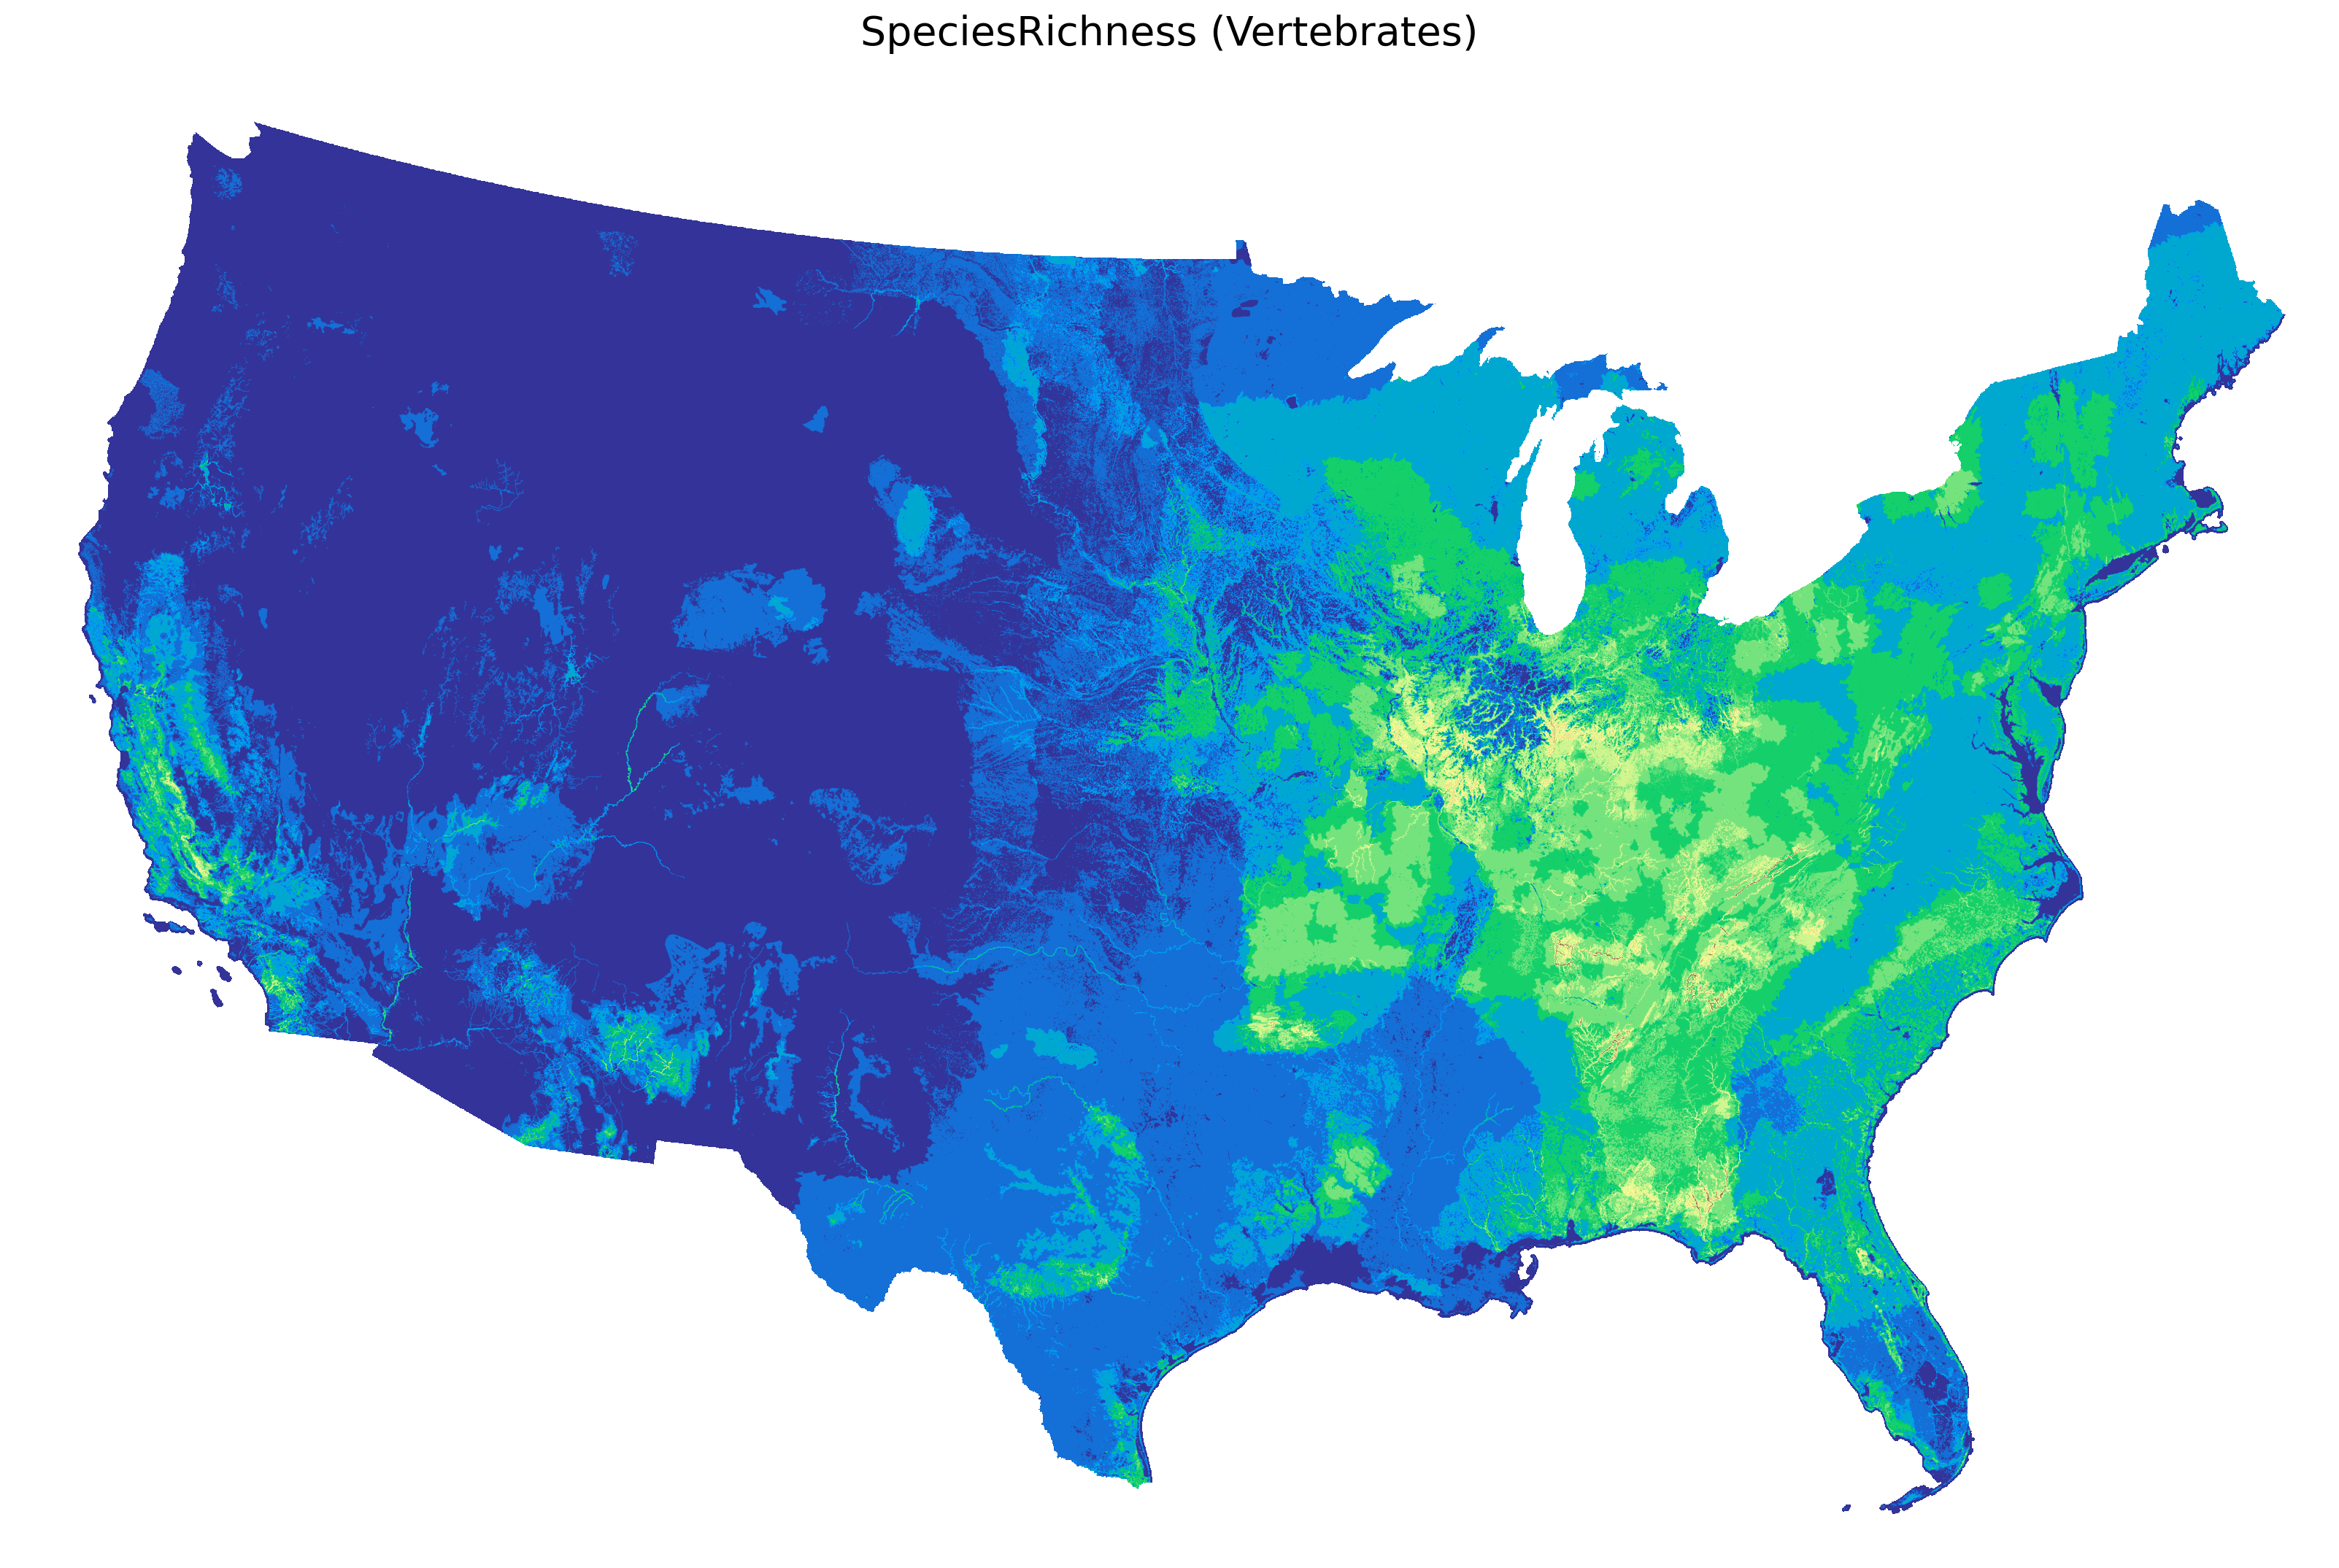

In [35]:
cmap = 'terrain'
w = raster.shape[0]; h = raster.shape[1]; dpi=200
fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.set_title('{} ({})'.format(layer_type,taxonomic_grouping),fontsize=20)
plt.imshow(data_array,cmap=cmap)